# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
import itertools
import pickle
from matplotlib import pyplot as plt
import datetime
from scipy import optimize
import sys
sys.path.append('../SEIR_full/')
sys.path.append('..')
import SEIR_full as mdl
import SEIR_full.model_class as mdl
import datetime as dt
from scipy.stats import poisson
from scipy.stats import binom
import copy
import os
import time

In [2]:
with (open('../Data/parameters/indices.pickle', 'rb')) as openfile:
    ind = pickle.load(openfile)

# setting calibration settings:

In [21]:
# cal_parameters = {}
# old_cal_parameters = pd.read_pickle('../Data/calibration/calibrattion_dict.pickle')
# del old_cal_parameters['250']
# cal_parameters['20'] = old_cal_parameters
# cal_parameters['250'] = {
#     'base':{
#         'beta_j': mdl.Beta2beta_j([0.10167117, 0.05606748, 0.04709613, 0.25676354]),
#         'theta': 2.0684200685446243,
#         'beta_behave': 0.18876288297385702,
#     }
# }
# cal_parameters
# with open('../Data/calibration/calibrattion_dict.pickle', 'wb') as handle:
#     pickle.dump(cal_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# cal_parameters = pd.read_pickle('../Data/calibration/calibrattion_dict.pickle')
# cal_parameters

{'20': {'80%': {'beta_j': array([0.1157294 , 0.1157294 , 0.1157294 , 0.06716495, 0.06716495,
          0.07727618, 0.07727618, 0.41851232, 0.41851232]),
   'beta_behave': 0.23409992936184507,
   'theta': 1.5},
  '75%': {'beta_j': array([0.11383349, 0.11383349, 0.11383349, 0.06559511, 0.06559511,
          0.07315267, 0.07315267, 0.40333246, 0.40333246]),
   'beta_behave': 0.2348158677677705,
   'theta': 1.5247164304657486},
  '70%': {'beta_j': array([0.1117097 , 0.1117097 , 0.1117097 , 0.06382757, 0.06382757,
          0.06940131, 0.06940131, 0.38820894, 0.38820894]),
   'beta_behave': 0.2355405990831057,
   'theta': 1.56973015443624},
  'ub': {'beta_j': array([0.12501922, 0.12501922, 0.12501922, 0.07354475, 0.07354475,
          0.09657314, 0.09657314, 0.48909651, 0.48909651]),
   'beta_behave': 0.2280608311545828,
   'theta': 1.5},
  'base': {'beta_j': array([0.09883986, 0.09883986, 0.09883986, 0.05334751, 0.05334751,
          0.05144386, 0.05144386, 0.30902021, 0.30902021]),
   'be

# Intervention of slipped civil of const inter for 2000[d]

In [3]:
pct = range(30, 105, 10)
slipped_pct = np.arange(0, 11, 2)/10.0

# interventions to examine:
inter_list = ['20@' + str(x) + '_no_risk60_school_kid010' for x in pct]
inter_list = [x + '_slipped_risk('+str(slipped_pct[5])+')' for x in inter_list]

# parameters to examine:
parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
    'base',
#     'lb',
]

results = {}

In [4]:
scen = 'Scenario2'
start_inter = pd.Timestamp('2020-05-03')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibrattion_dict.pickle')
cal_parameters = {key : cal_parameters[key] for key in parameters_list}

for key in cal_parameters.keys():
    model = mdl.Model_behave(
        ind=ind, 
        beta_j=cal_parameters[key]['beta_j'],
        theta=cal_parameters[key]['theta'],
        beta_behave=cal_parameters[key]['beta_behave'],
        eps=mdl.eps_sector[scen],
        f=mdl.f0_full[scen],
    )

    res_mdl = model.predict(
        C=mdl.C_calibration,
        days_in_season=(start_inter-beginning).days,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )
    for pct_i in pct:
        for slipped_pct_i in slipped_pct:
            inter_name = '20@' + str(pct_i) + '_no_risk60_school_kid010' + '_slipped_risk('+str(slipped_pct_i)+')'
            # First intervention
            with open('../Data/interventions/C_inter_' + inter_name + '.pickle', 'rb') as pickle_in:
                C_inter = pickle.load(pickle_in)

            with open('../Data/interventions/stay_home_idx_inter_' + inter_name + '.pickle', 'rb') as pickle_in:
                stay_home_idx_inter = pickle.load(pickle_in)

            with open('../Data/interventions/routine_t_inter_' + inter_name + '.pickle', 'rb') as pickle_in:
                routine_t_inter = pickle.load(pickle_in)

            with open('../Data/interventions/transfer_pop_inter_' + inter_name + '.pickle', 'rb') as pickle_in:
                transfer_pop_inter = pickle.load(pickle_in)

            model_inter = copy.deepcopy(model)
            res_mdl = model_inter.intervention(
                C =C_inter,
                days_in_season=2000,
                stay_home_idx=stay_home_idx_inter,
                not_routine=routine_t_inter,
                prop_dict=transfer_pop_inter,
            )
    #         # fix 60 offset
    #         for i, vent in enumerate(res_mdl['Vents']):
    #             res_mdl['Vents'][i] = vent + ((60.0/mdl.pop_israel)*vent)/vent.sum()

            print(key, ' parameters, intervention: ', inter_name, ' we got:')
    #         ['Vents'].sum()*mdl.pop_israel*model.mu*0.5
            results[(pct_i, slipped_pct_i, key)] = res_mdl
    #         print('number ot total casulties is: ', results[(inter_name, key)])
    #         print('Recovered cases max: ', (((res_mdl['R'])[:(start_inter-beginning).days+90].sum(axis=1))*mdl.pop_israel).max())
    #         mdl.plot_I_by_age(model.ind, res_mdl)
    #         mdl.plot_R_by_age(ind, res_mdl)
#             mdl.plot_respiration_cases(res_mdl, (start_inter-beginning).days)
    #         mdl.plot_hospitalization_cases(res_mdl)
    #         results[(inter_name, key)] = res_mdl

base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(0.0)  we got:
base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(0.2)  we got:
base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(0.4)  we got:
base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(0.6)  we got:
base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(0.8)  we got:
base  parameters, intervention:  20@30_no_risk60_school_kid010_slipped_risk(1.0)  we got:
base  parameters, intervention:  20@40_no_risk60_school_kid010_slipped_risk(0.0)  we got:
base  parameters, intervention:  20@40_no_risk60_school_kid010_slipped_risk(0.2)  we got:
base  parameters, intervention:  20@40_no_risk60_school_kid010_slipped_risk(0.4)  we got:
base  parameters, intervention:  20@40_no_risk60_school_kid010_slipped_risk(0.6)  we got:
base  parameters, intervention:  20@40_no_risk60_school_kid010_slipped_risk(0.8)  we got:
base  para

KeyboardInterrupt: 

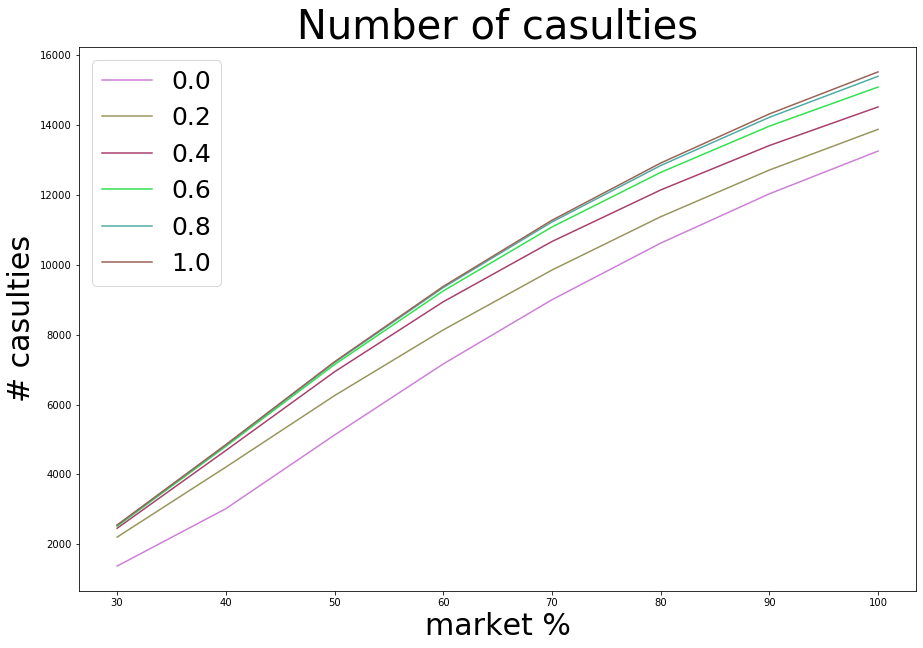

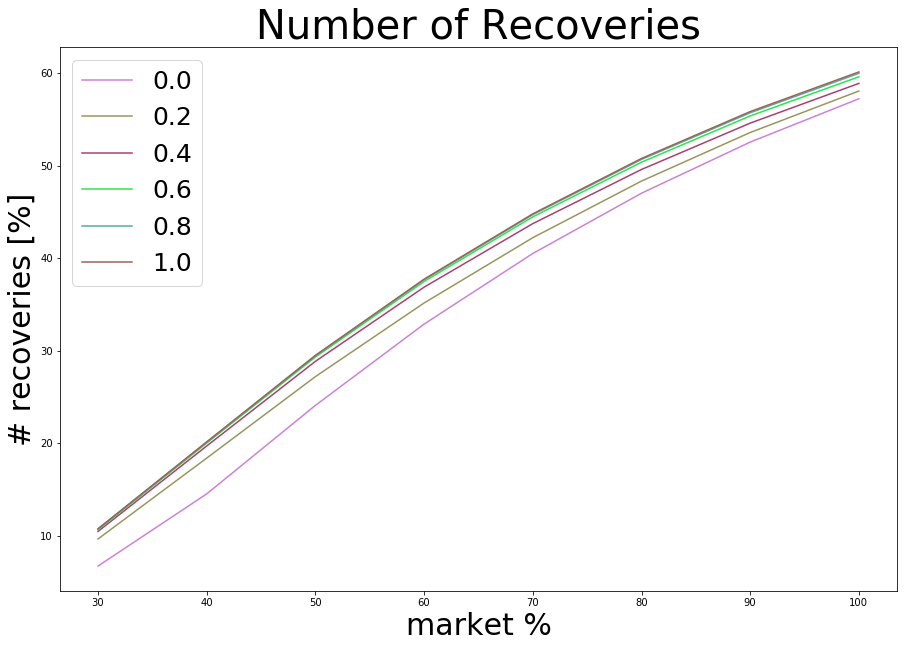

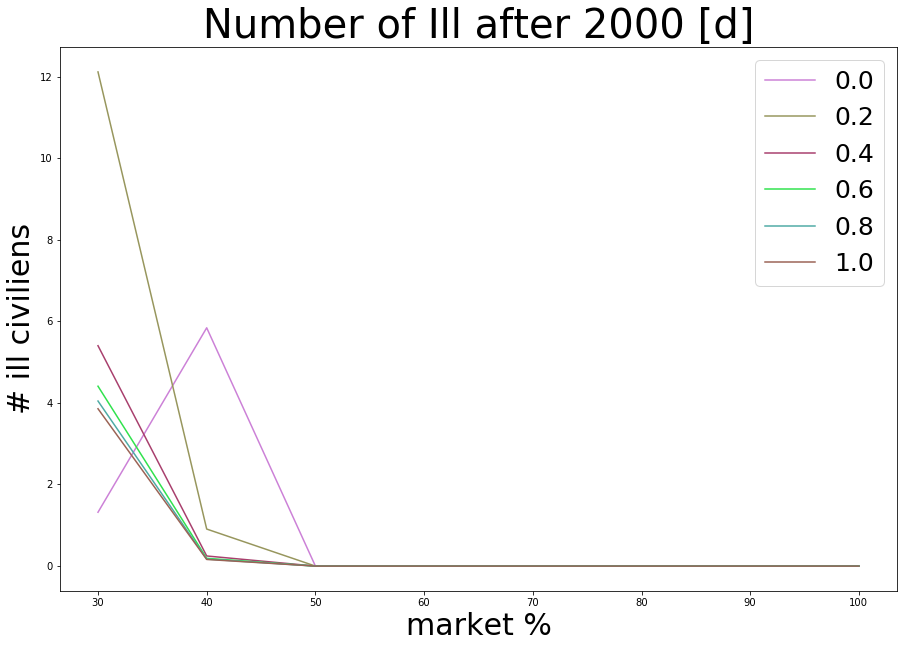

In [11]:
def make_casulties(res_model, time_ahead):
    return (res_model['Vents'].sum(axis=1))[:time_ahead].sum()*mdl.pop_israel*model.mu*0.5

def make_recoveries(res_model, time_ahead):
    return (res_model['R'].sum(axis=1))[time_ahead]*100

def make_ill_end(res_model, time_ahead):
    return ((res_model['Ie']+res_model['Is']+res_model['Ia']).sum(axis=1))[time_ahead]*mdl.pop_israel

key = 'base'
plt.figure(figsize=(15,10))
c = np.random.rand(len(slipped_pct),3)
for i, slipped_pct_i in enumerate(slipped_pct):
    plt.plot(pct, [make_casulties(results[(pct_i, slipped_pct_i, key)], 2000) for pct_i in pct], c=c[i,:])
#     plt.plot(pct, [make_casulties(results[(pct_i, slipped_pct_i, key)], 300) for pct_i in pct], c=c[i,:], label='_nolegend_')
plt.title('Number of casulties', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# casulties', fontsize=30)
plt.legend(slipped_pct, fontsize=25)

plt.figure(figsize=(15,10))
for i, slipped_pct_i in enumerate(slipped_pct):

    plt.plot(pct, [make_recoveries(results[(pct_i, slipped_pct_i, key)], 2000) for pct_i in pct], c=c[i,:])
plt.title('Number of Recoveries', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# recoveries [%]', fontsize=30)
plt.legend(slipped_pct, fontsize=25)

plt.figure(figsize=(15,10))
for i, slipped_pct_i in enumerate(slipped_pct):
    plt.plot(pct, [make_ill_end(results[(pct_i, slipped_pct_i, key)], 2000) for pct_i in pct], c=c[i,:])
plt.title('Number of Ill after 2000 [d]', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# ill civiliens', fontsize=30)
plt.legend(slipped_pct, fontsize=25)

# Comparing UB to base in case of no degredation

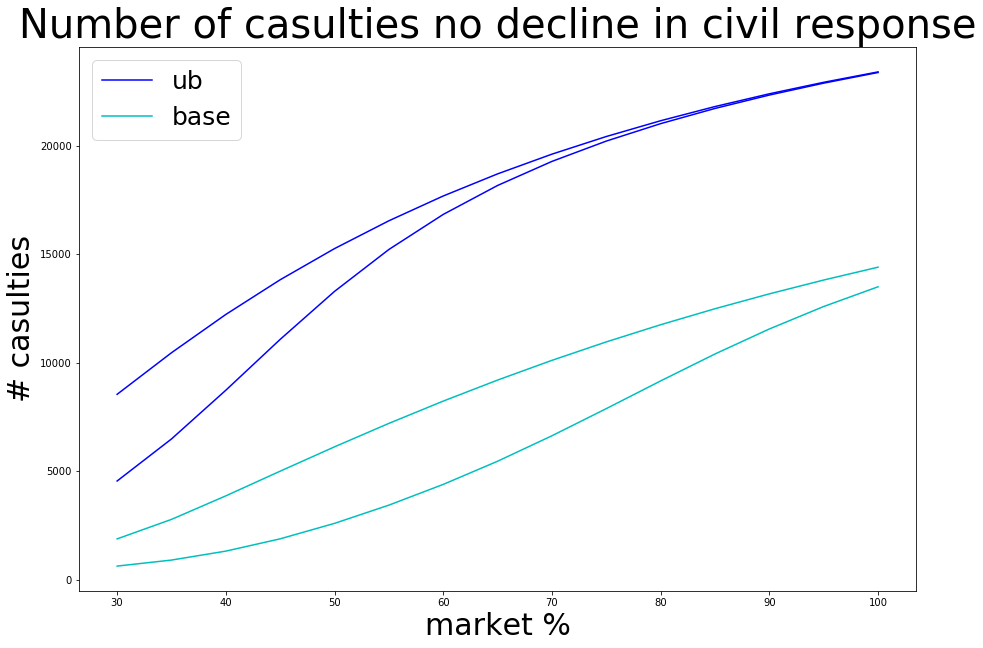

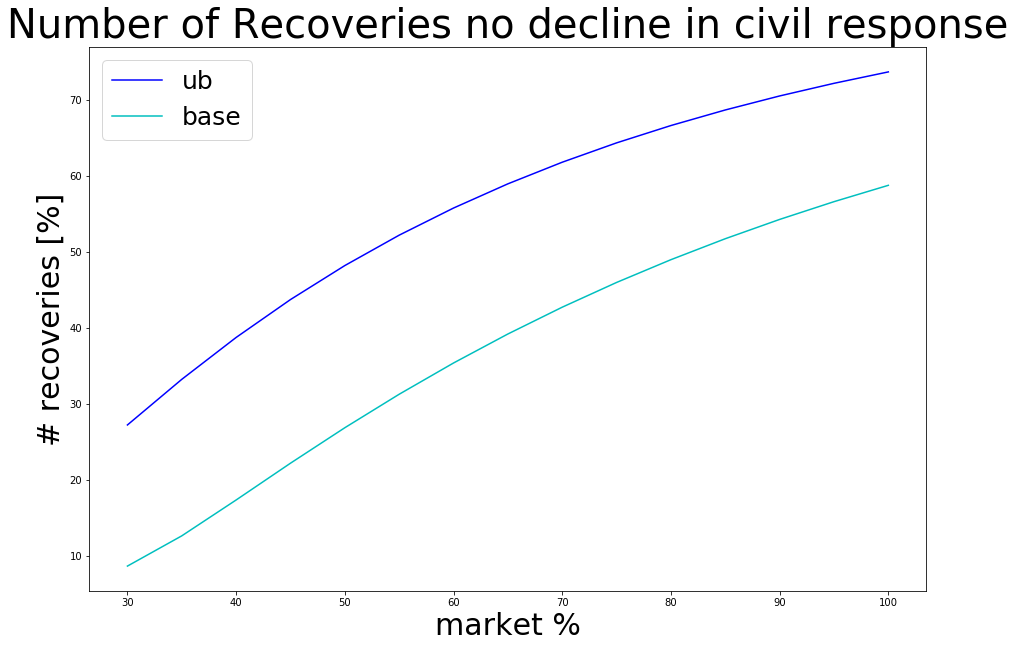

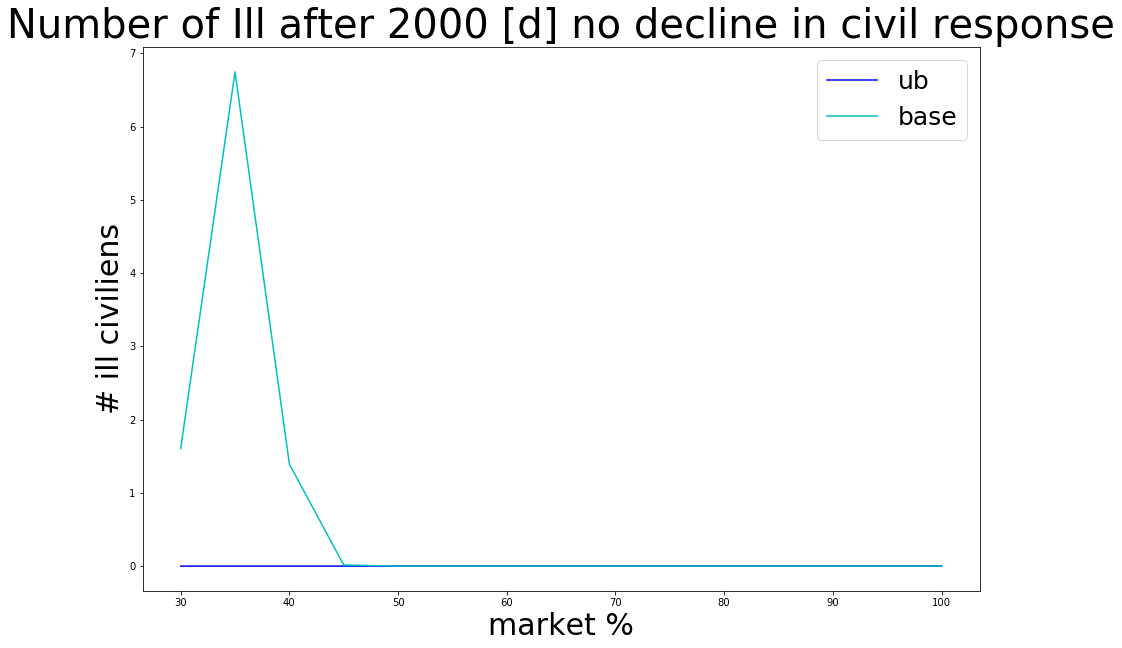

In [51]:
def make_casulties(res_model, time_ahead):
    return (res_model['Vents'].sum(axis=1))[:time_ahead].sum()*mdl.pop_israel*model.mu*0.5

def make_recoveries(res_model, time_ahead):
    return (res_model['R'].sum(axis=1))[time_ahead]*100

def make_ill_end(res_model, time_ahead):
    return ((res_model['Ie']+res_model['Is']+res_model['Ia']).sum(axis=1))[time_ahead]*mdl.pop_israel

plt.figure(figsize=(15,10))
c_casul=['b', 'c']
for i, key in enumerate(cal_parameters.keys()):
    plt.plot(pct, [make_casulties(results[(inter_name, key)], 2000) for inter_name in inter_list], c=c[i])
    plt.plot(pct, [make_casulties(results[(inter_name, key)], 300) for inter_name in inter_list], c=c[i], label='_nolegend_')
plt.title('Number of casulties no decline in civil response', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# casulties', fontsize=30)
plt.legend(list(cal_parameters.keys()), fontsize=25)

plt.figure(figsize=(15,10))
c_casul=['b', 'c']
for i, key in enumerate(cal_parameters.keys()):
    plt.plot(pct, [make_recoveries(results[(inter_name, key)], 2000) for inter_name in inter_list], c=c[i])
plt.title('Number of Recoveries no decline in civil response', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# recoveries [%]', fontsize=30)
plt.legend(list(cal_parameters.keys()), fontsize=25)

plt.figure(figsize=(15,10))
c_casul=['b', 'c']
for i, key in enumerate(cal_parameters.keys()):
    plt.plot(pct, [make_ill_end(results[(inter_name, key)], 2000) for inter_name in inter_list], c=c[i])
plt.title('Number of Ill after 2000 [d] no decline in civil response', fontsize=40)
plt.xlabel('market %', fontsize=30)
plt.ylabel('# ill civiliens', fontsize=30)
plt.legend(list(cal_parameters.keys()), fontsize=25)

# Comparing slow release to sudden period of 3 [m]

In [19]:
last = 100

pct_ramp = range(30, last+5, 5)
single_pct_list = [50, 75, 100] # the single to compare ramp to.

# interventions to examine:
inter_rmp = [mdl.inter2name(ind, x, no_risk=True) for x in pct_ramp]

time2last_inter = 150 # dayes

# deg_param = {
#     'inter_max':mdl.inter2name(ind, last, no_risk=False),
#     'deg_rate': last/float(time2last_inter),
#     'max_deg_rate': last,
# }
deg_param = None

# parameters to examine:
parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
    'base',
#     'lb',
]

results = {}

In [20]:
inter_lists = [
        [mdl.inter2name(ind, single_pct, no_risk=True),inter_rmp[-1]] 
    for single_pct in single_pct_list]
inter_lists.append(inter_rmp)
for i in range(len(inter_lists)):
    inter_lists[i][-1] = mdl.inter2name(ind, pct_ramp[-1], no_risk=True)
    
inter_times_lists = [
    [time2last_inter]
]*len(single_pct_list)
delta_t = int(time2last_inter/(float(len(inter_rmp)-1)))
inter_times_lists.append([delta_t] * (len(inter_rmp)-1))

In [21]:
scen = 'Scenario2'
start_inter = pd.Timestamp('2020-05-03')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibrattion_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}

for key in cal_parameters.keys():
    model = mdl.Model_behave(
        ind=ind, 
        beta_j=cal_parameters[key]['beta_j'],
        theta=cal_parameters[key]['theta'],
        beta_behave=cal_parameters[key]['beta_behave'],
        eps=mdl.eps_sector[scen],
        f=mdl.f0_full[scen],
    )

    model.predict(
        C=mdl.C_calibration,
        days_in_season=(start_inter-beginning).days,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )
    
    _, model = mdl.multi_inter_by_name(
            ind, 
            model, 
            mdl.pop_israel, 
            [mdl.inter2name(ind, 30, no_risk=True, no_school=True, no_kid010=True)],
            sim_length=7, 
            fix_vents=False,
    )
    
    for i in range(len(inter_times_lists)):
        res_mdl, _ = mdl.multi_inter_by_name(
            ind, 
            model, 
            mdl.pop_israel, 
            inter_lists[i], 
            inter_times_lists[i], 
            sim_length=500, 
            fix_vents=False,
            deg_param = deg_param,
            no_pop=True,
        )
        results[(key, i)] = res_mdl
#     # fix 60 offset
#     for i, vent in enumerate(res_mdl['Vents']):
#         res_mdl['Vents'][i] = vent + ((60.0/mdl.pop_israel)*vent)/vent.sum()

    print(key, ' parameters, we got:')

base  parameters, we got:


Recovered cases max:  38.39302435113842
total casulties:  4434.8635170859225
Recovered cases max:  38.58694806949506
total casulties:  4486.566842745145
Recovered cases max:  40.82947559500943
total casulties:  4779.842493598818
Recovered cases max:  39.65917301636657
total casulties:  4627.1061423048595


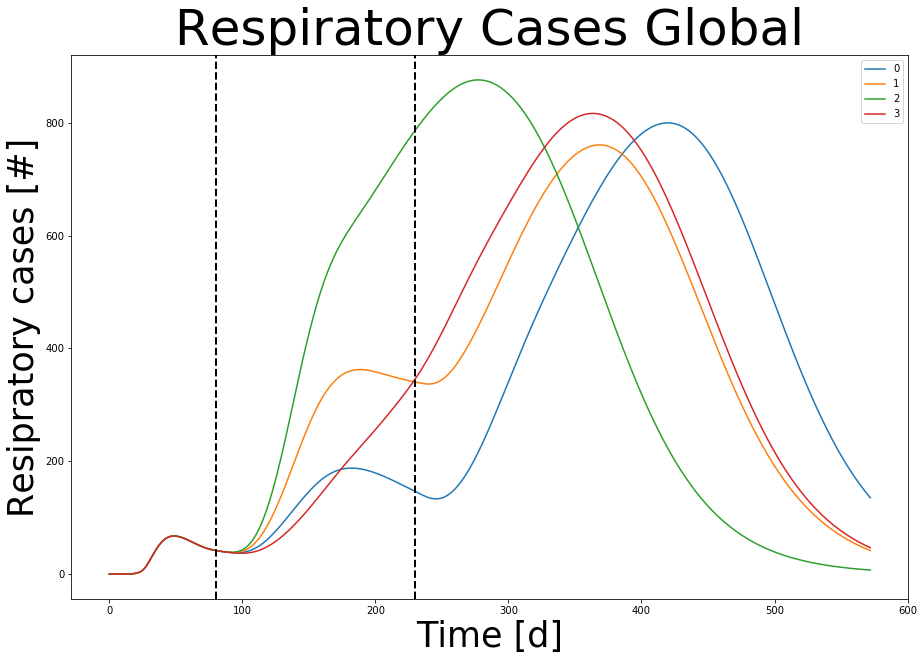

In [25]:
for key in cal_parameters.keys():
    for i in range(len(inter_times_lists)):
        print('Recovered cases max: ', mdl.make_recoveries(results[(key, i)], -1))
        print('total casulties: ', mdl.make_casulties(results[(key, i)], -1, mdl.pop_israel, model.mu))

fig, ax = plt.subplots(figsize=(15, 10))
for key in cal_parameters.keys():
    for i in range(len(inter_times_lists)):
        ax.plot(((results[(key, i)]['Vents']).sum(axis=1))[:573]*mdl.pop_israel, label=str(i))
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases Global', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
ax.axvline(x=(start_inter-beginning).days+time2last_inter+7, c='k', linewidth=2, linestyle='--')
ax.legend()
plt.show()

In [18]:
rmp = ((res_rmp['Vents']).sum(axis=1))*mdl.pop_israel
single = ((res_single['Vents']).sum(axis=1))*mdl.pop_israel

f = 1/365
phi = (pd.Timestamp('2020-05-24')-beginning).days
season = np.sin(np.arange(0,len(rmp))*2*np.pi*f-phi)
rmp *= 1+0.2*season
single *= 1+0.2*season

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(rmp)
ax.plot(single)
ax.set_ylabel('Resipratory cases [#]', fontsize=35)
ax.set_title('Respiratory Cases Global', fontsize=50)
ax.set_xlabel('Time [d]', fontsize=35)
ax.axvline(x=(start_inter-beginning).days, c='k', linewidth=2, linestyle='--')
ax.axvline(x=(start_inter-beginning).days+time2last_inter, c='k', linewidth=2, linestyle='--')
ax.legend(['ramping up from 30%', '75%'])

plt.show()

NameError: name 'res_rmp' is not defined

In [27]:
results[('base', 0)]

{'S': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.19889704e-04, 9.67655130e-05, 4.48368223e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.19889704e-04, 9.67655130e-05, 4.48368223e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.19889704e-04, 9.67655130e-05, 4.48368223e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 8.27754618e-05, 3.99077920e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 8.27750644e-05, 3.99076528e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 8.27746761e-05, 3.99075167e-05]]),
 'E': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.57537740e-11, 1.06967790e-11, 6.55679466e-12],
        [0.0000